# Импорт библиотек и датасетов для Классификации

In [ ]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gauravduttakiit/banknote")
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


path2 = "Dataset/Water"

print("Path to dataset files:", path2)

TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1
Path to dataset files: Dataset/steam


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             confusion_matrix)

Загрузим train и тест. Все так замечательно, что не нужно разбивать на train и тест данные.

# Анализ и визуализация данных

In [93]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [94]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1096, 5)
Test shape: (275, 4)


Они разбиты уже соотношением 80 к 20 примерно

Посмотрим теперь на эти данные в целом. Видим 4 параметра и класс, к которому принадлежит данный объект

In [95]:
print('\nTrain columns:', train.columns.tolist())
train.head()


Train columns: ['VWTI', 'SWTI', 'CWTI', 'EI', 'Class']


,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [96]:
print('\nTrain info:')
print(train.info())


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    1096 non-null   float64
 1   SWTI    1096 non-null   float64
 2   CWTI    1096 non-null   float64
 3   EI      1096 non-null   float64
 4   Class   1096 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 42.9 KB
None


In [97]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    275 non-null    float64
 1   SWTI    275 non-null    float64
 2   CWTI    275 non-null    float64
 3   EI      275 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB
None


Пропусков не обнаружено, попался хороший чистый датасет

In [98]:
cols = train.columns.tolist()
target_col = "Class"

Таргет - последний столбец Class


In [99]:
print('\nClass distribution in train:')
print(train[target_col].value_counts())


Class distribution in train:
Class
0    608
1    488
Name: count, dtype: int64


Видим, что соотношение классов примерно равное

Дропаем таргет

In [100]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col].values

X_test = test.copy()

print('Features shape:', X_train.shape)
print('Feature names:', X_train.columns.tolist())

Features shape: (1096, 4)
Feature names: ['VWTI', 'SWTI', 'CWTI', 'EI']


Посмотрим корреляцию

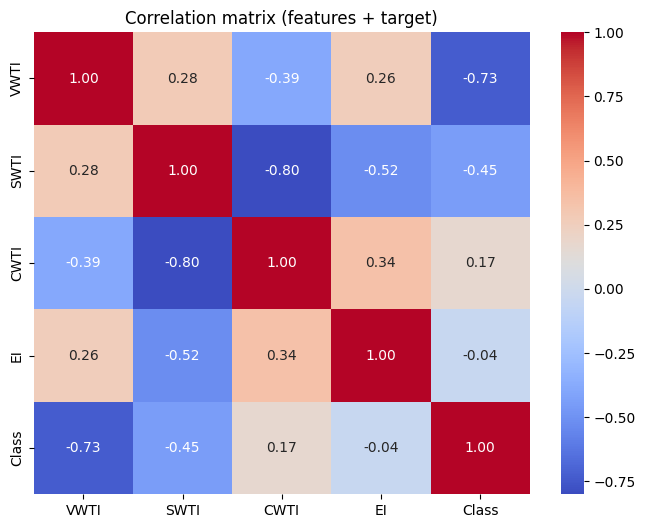

In [101]:

plt.figure(figsize=(8,6))
sns.heatmap(pd.concat([X_train, pd.Series(y_train, name=target_col)], axis=1).corr(),
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (features + target)')
plt.show()

По корреляции видно, что VWTI и SWTI фичи сильно влияют на наш таргет

Посмотрим на распределение фичей по нашим двум классам

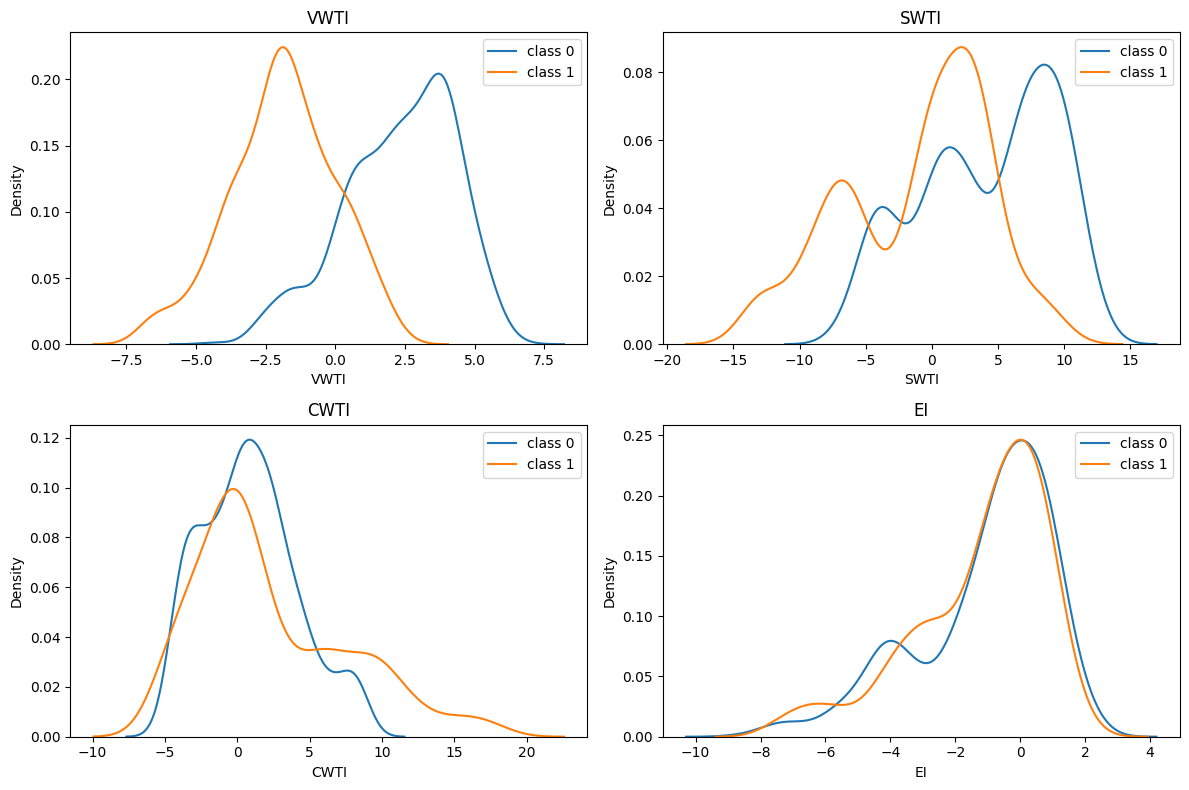

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for i, col in enumerate(X_train.columns[:4]):
    ax = axes.flatten()[i]
    sns.kdeplot(X_train[col][y_train==0], ax=ax, label='class 0')
    sns.kdeplot(X_train[col][y_train==1], ax=ax, label='class 1')
    ax.set_title(col)
    ax.legend()
plt.tight_layout()

В подтвержение сказаному выше можно увидеть на графике явное расхождение VWTI и SWTI по двум классам

# Обучение и тестирование модели Классификации

## Базовое решение sklearn

Разделяем dataset на train/test

In [103]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


Обучаем

In [120]:
baseline_model = KNeighborsClassifier(
    weights='uniform'
)
baseline_model.fit(X_train_sub, y_train_sub)

KNeighborsClassifier()

In [121]:
y_pred_baseline = baseline_model.predict(X_valid)

В качестве метрик я взял 3 штуки. Precision, Recall, Accuracy

In [122]:
acc_baseline = accuracy_score(y_valid, y_pred_baseline)
prec_baseline = precision_score(y_valid, y_pred_baseline, zero_division=0)
rec_baseline = recall_score(y_valid, y_pred_baseline, zero_division=0)

In [123]:
print(f'Accuracy: {acc_baseline:.4f}')
print(f'Precision: {prec_baseline:.4f}')
print(f'Recall: {rec_baseline:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


Вот оно как получается...
Ну тут не получится что-то взять и попытаться круче сделать...

Cofusion matrix

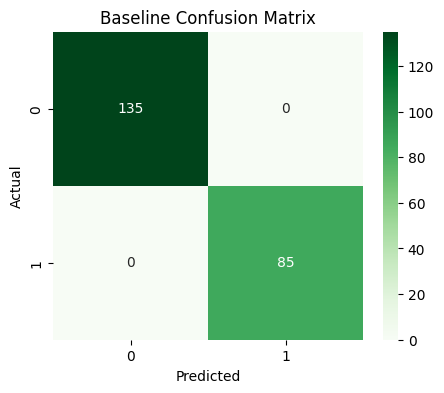

In [124]:
cm = confusion_matrix(y_valid, y_pred_baseline)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

При выборе датасет я не представлял, что такое произойдет, данные очень чистые. Формировать какие-либо гипотезы для улучшенного бейзлайна нет смысла, если результата лучше уже не будет. Тут не было выбросов, которые бы уменьшили точность модели, гиперпараметры даже не подбирались.

Я бы подобрал гиперпараметры для улучшения точности предсказания, добавлять какие-то фичи еще я бы не стал, провел работу с данными, а именно с пропусками и выбросами.


## Реализация KNN модели

In [117]:
import numpy as np


class CustomKNNClassifier:
    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None


    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)


    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            idx = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[idx]
            values, counts = np.unique(nearest_labels, return_counts=True)
            predictions.append(values[np.argmax(counts)])
        return np.array(predictions)

Обучение и оценка модели

In [118]:
custom_knn = CustomKNNClassifier(n_neighbors=5)
custom_knn.fit(X_train_sub, y_train_sub)


y_pred_custom = custom_knn.predict(X_valid)


acc_custom = accuracy_score(y_valid, y_pred_custom)
prec_custom = precision_score(y_valid, y_pred_custom, zero_division=0)
rec_custom = recall_score(y_valid, y_pred_custom, zero_division=0)

print(f'Accuracy: {acc_custom:.4f}')
print(f'Precision: {prec_custom:.4f}')
print(f'Recall: {rec_custom:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


Результаты сравнения с KNN из sklearn одинаковы

# Импорт и загрузка датасетов для задачи Регрессии

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
DATA_PATH = "Dataset/Water/water_consumption.csv"

# Анализ и визуаллизация данных

Посмотрим на данные

In [16]:
df = pd.read_csv(DATA_PATH)
df.head(20)


,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate
5,Argentina,2005,458.077000,265.012000,59.834000,29.288000,22.649000,1826.293000,2.724000,Moderate
6,Argentina,2006,452.983333,111.708333,54.961667,29.791667,28.831667,1318.923333,3.133333,Moderate
7,Argentina,2007,691.102500,192.815000,41.655000,16.705000,20.310000,1500.837500,3.500000,Moderate
8,Argentina,2008,494.048000,230.443000,60.323000,24.483000,24.210000,1378.952000,3.006000,Moderate
9,Argentina,2009,637.878333,230.681667,54.916667,29.051667,21.211667,1141.906667,2.356667,Moderate


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Country                                         500 non-null    object 
 1   Year                                            500 non-null    int64  
 2   Total Water Consumption (Billion Cubic Meters)  500 non-null    float64
 3   Per Capita Water Use (Liters per Day)           500 non-null    float64
 4   Agricultural Water Use (%)                      500 non-null    float64
 5   Industrial Water Use (%)                        500 non-null    float64
 6   Household Water Use (%)                         500 non-null    float64
 7   Rainfall Impact (Annual Precipitation in mm)    500 non-null    float64
 8   Groundwater Depletion Rate (%)                  500 non-null    float64
 9   Water Scarcity Level                       

Переименуем стоблцы

In [19]:
df = pd.read_csv(DATA_PATH)

df = df.rename(columns={
    "Country": "country",
    "Year": "year",
    "Total Water Consumption (Billion Cubic Meters)": "total_consumption",
    "Per Capita Water Use (Liters per Day)": "per_capita_use",
    "Agricultural Water Use (%)": "agricultural_use",
    "Industrial Water Use (%)": "industrial_use",
    "Household Water Use (%)": "household_use",
    "Rainfall Impact (Annual Precipitation in mm)": "rainfall",
    "Groundwater Depletion Rate (%)": "groundwater_depletion",
    "Water Scarcity Level": "scarcity_level"
})

df.head()

,country,year,total_consumption,per_capita_use,agricultural_use,industrial_use,household_use,rainfall,groundwater_depletion,scarcity_level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


Посмотрим на пропуски

In [21]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                500 non-null    object 
 1   year                   500 non-null    int64  
 2   total_consumption      500 non-null    float64
 3   per_capita_use         500 non-null    float64
 4   agricultural_use       500 non-null    float64
 5   industrial_use         500 non-null    float64
 6   household_use          500 non-null    float64
 7   rainfall               500 non-null    float64
 8   groundwater_depletion  500 non-null    float64
 9   scarcity_level         500 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 39.2+ KB
None

Missing values:
 country                  0
year                     0
total_consumption        0
per_capita_use           0
agricultural_use         0
industrial_use           0
household_use          

Пропусков нет, анализировать нечего

Посмотрим на корреляцию признаков

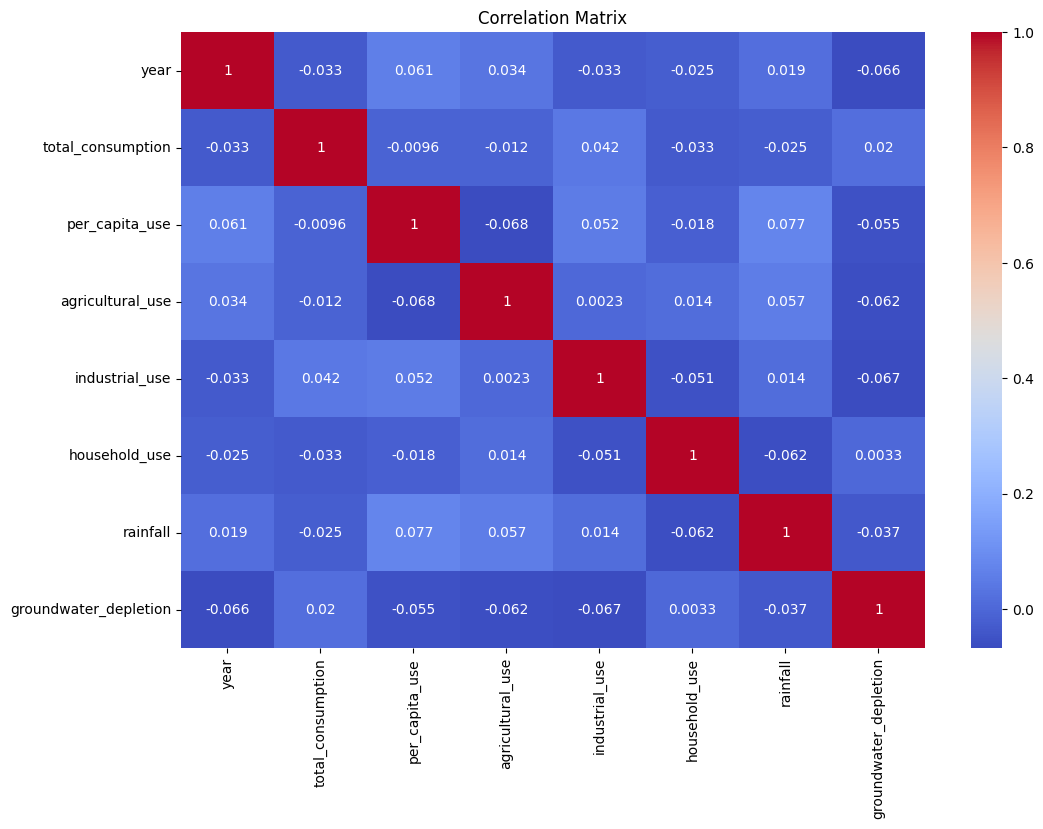

In [38]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Рапсределение потребления воды по странам

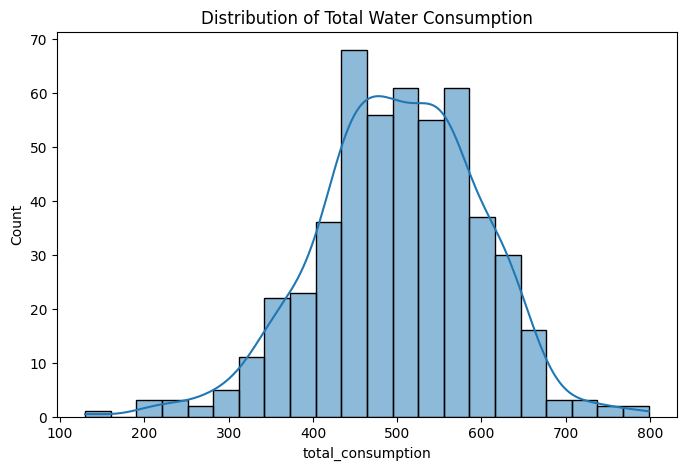

In [39]:
plt.figure(figsize=(8,5))
sns.histplot(df["total_consumption"], kde=True)
plt.title("Distribution of Total Water Consumption")
plt.show()


Соответствует нормальному

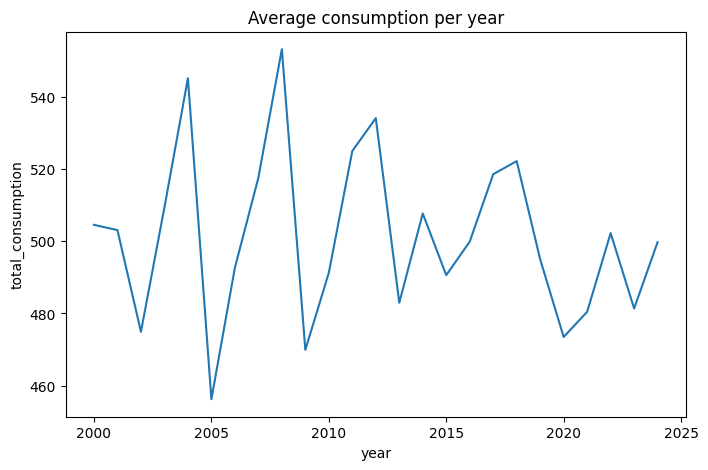

In [40]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df.groupby("year")["total_consumption"].mean())
plt.title("Average consumption per year")
plt.show()


In [ ]:
Посмотрим на распределение потребления воды

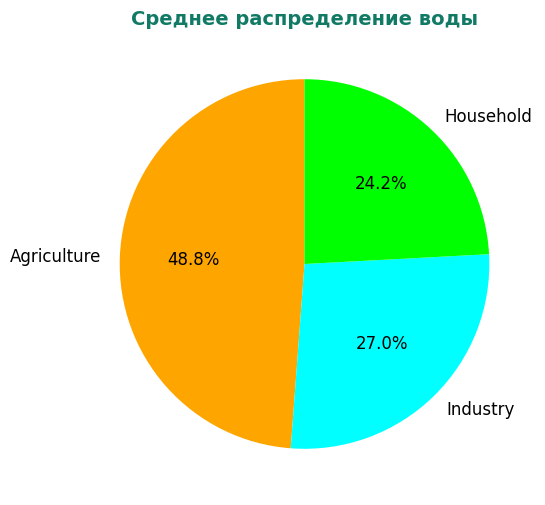

In [65]:
plt.figure(figsize=(8,6))
avg_use = df[['agricultural_use', 'industrial_use', 'household_use']].mean()
colors = ['orange', 'cyan', 'lime']
plt.pie(avg_use, labels=['Agriculture', 'Industry', 'Household'], autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title("Среднее распределение воды", fontsize=14, fontweight='bold', color="#117a65")
plt.show()

Среднее потребление воды в год странами

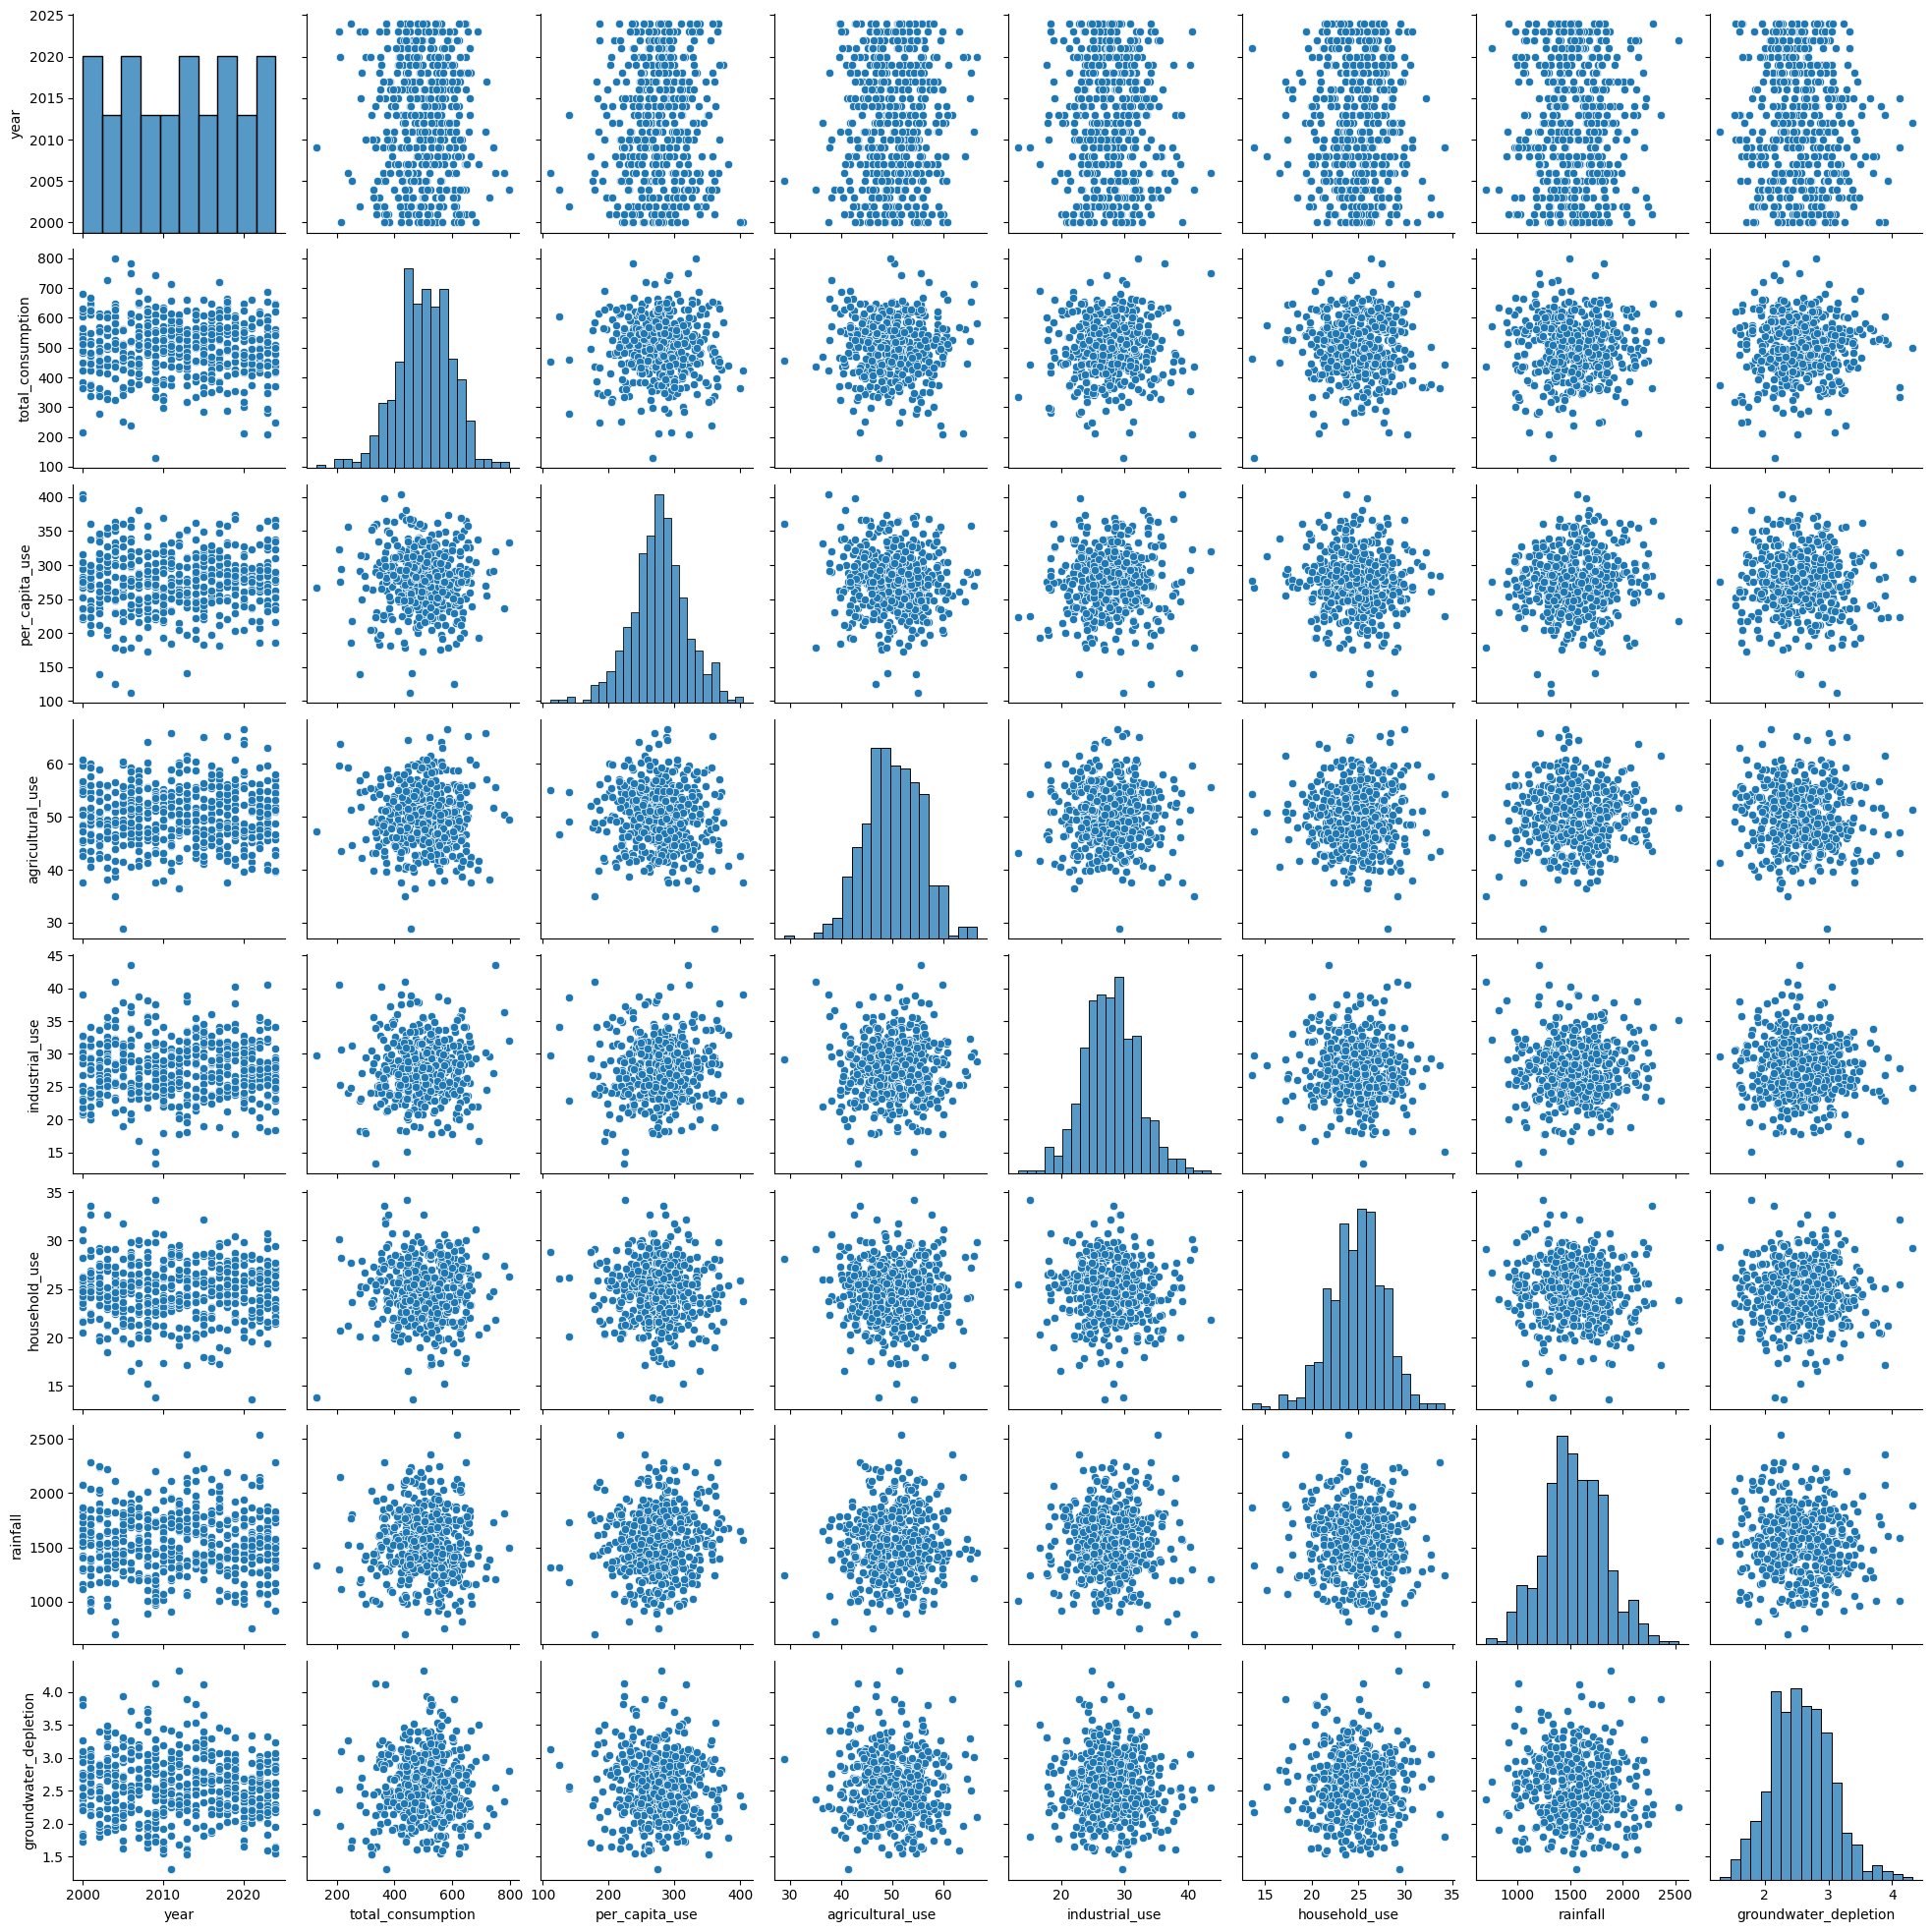

In [42]:
sns.pairplot(df.select_dtypes(include=[np.number]))
plt.show()

Наша ключевая фича - total_consumption

Посмотрим на признаки

In [45]:
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=[object]).columns

print("Числовые:", numeric_features.tolist())
print("Категориальные:", categorical_features.tolist())


Числовые: ['year', 'per_capita_use', 'agricultural_use', 'industrial_use', 'household_use', 'rainfall', 'groundwater_depletion']
Категориальные: ['country', 'scarcity_level']


# Обучение и тестирование модели 

Разобьем датасет на train и test

In [56]:
df_sorted = df.sort_values("year")

train = df_sorted[df_sorted.year < df_sorted.year.max() - 2]
test = df_sorted[df_sorted.year >= df_sorted.year.max() - 2]

X_train = train.drop(columns=["total_consumption"])
y_train = train["total_consumption"]

X_test = test.drop(columns=["total_consumption"])
y_test = test["total_consumption"]

len(train), len(test)


(440, 60)

Базовая модель

In [52]:
preprocessor_baseline = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

baseline_model = Pipeline([
    ("prep", preprocessor_baseline),
    ("knn", KNeighborsRegressor(n_neighbors=5))
])


In [53]:
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [57]:
mse_base = np.sqrt(mean_squared_error(y_valid, y_pred_base))
mae_base = mean_absolute_error(y_valid, y_pred_base)

In [88]:
print("RMSE:", mse_base)
print("MAE:", mae_base)

RMSE: 106.82297763635034
MAE: 79.33057359966666


Получили ошибку в 107 миллиардов кубических метров воды для RMSE, и 79 для MAE

Посмотрим, какая ошибка в %

In [66]:
mean_consumption = y_valid.mean()

mae_percent = (mae_best / mean_consumption) * 100
rmse_percent = (rmse_best / mean_consumption) * 100

print("MAE%:", mae_percent)
print("RMSE%:", rmse_percent)
mape = np.mean(np.abs((y_valid - y_pred_best) / y_valid)) * 100
print("MAPE:", mape)


MAE%: 15.47811805449116
RMSE%: 19.785471744401203
MAPE: 18.356114389726688


# Дальнейший анализ и гипотезы

Будем предсказывать для каждой страны отдельно

KNN плохо себя ведет на таких рознящихся данных, для этого попробуем поизменять гиперпараметры

Функция для рассчета метрик

In [92]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mean_val = y_true.mean()
    mae_percent = (mae / mean_val) * 100
    rmse_percent = (rmse / mean_val) * 100
    
    return mae, rmse, mae_percent, rmse_percent


Для каждой страны будем тренировать модель

In [93]:
baseline_results = []

countries = df["country"].unique()

for country in countries:
    df_c = df[df.country == country].sort_values("year")

    # Split по годам
    train_c = df_c[df_c.year < df_c.year.max() - 2]
    valid_c = df_c[df_c.year >= df_c.year.max() - 2]

    if valid_c.shape[0] == 0 or train_c.shape[0] == 0:
        continue

    X_train = train_c.drop(columns=["total_consumption"])
    y_train = train_c["total_consumption"]

    X_valid = valid_c.drop(columns=["total_consumption"])
    y_valid = valid_c["total_consumption"]

    numeric = X_train.select_dtypes(include=[np.number]).columns
    categorical = X_train.select_dtypes(include=[object]).columns

    prep = ColumnTransformer([
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical)
    ], remainder="passthrough")

    model = Pipeline([
        ("prep", prep),
        ("knn", KNeighborsRegressor(n_neighbors=3))
    ])

    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    mae, rmse, mae_p, rmse_p, mape, = evaluate(y_valid, preds)

    baseline_results.append([country, mae, rmse, mae_p, rmse_p])


Для наглядности результаты в датафрейм засунем

In [107]:
baseline_df = pd.DataFrame(
    baseline_results,
    columns=["country", "MAE", "RMSE", "MAE_p", "RMSE_p"]
)

In [108]:
baseline_df.head(21)

,country,MAE,RMSE,MAE_p,RMSE_p
0,Argentina,82.119342,105.949178,14.253233,18.389314
1,Australia,190.334489,215.793320,42.948798,48.693560
2,Brazil,129.319913,132.250740,25.470560,26.047809
3,Canada,56.731432,68.780359,10.628071,12.885318
4,China,94.383142,111.501303,20.140642,23.793526
5,France,129.282988,160.092182,34.440219,42.647606
6,Germany,98.274135,135.538277,17.940629,24.743458
7,India,65.694850,72.736731,13.792485,15.270912
8,Indonesia,130.950375,141.317494,24.226218,26.144167
9,Italy,99.969283,103.226769,22.514093,23.247712


Для некоторых стран ошибка в 40%, что не есть хорошо

Теперь попробуем изменить гиперпараметры

In [113]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
improved_results = []

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

for country in countries:
    df_c = df[df.country == country].sort_values("year")

    if df_c.shape[0] < 5:
        continue

    train_c = df_c[df_c.year < df_c.year.max() - 2]
    valid_c = df_c[df_c.year >= df_c.year.max() - 2]

    if valid_c.shape[0] == 0 or train_c.shape[0] == 0:
        continue

    X_train = train_c.drop(columns=["total_consumption"])
    y_train = train_c["total_consumption"]

    X_valid = valid_c.drop(columns=["total_consumption"])
    y_valid = valid_c["total_consumption"]

    numeric = X_train.select_dtypes(include=[np.number]).columns
    categorical = X_train.select_dtypes(include=[object]).columns

    prep = ColumnTransformer([
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scale", StandardScaler(), numeric)
    ])

    pipe = Pipeline([
        ("prep", prep),
        ("knn", KNeighborsRegressor())
    ])

    gs = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    best = gs.best_estimator_
    preds = best.predict(X_valid)

    mae, rmse, mae_p, rmse_p = evaluate(y_valid, preds)

    improved_results.append([country, mae, rmse, mae_p, rmse_p])


In [115]:
improved_df = pd.DataFrame(improved_results, 
    columns=["country", "MAE", "RMSE", "MAE%", "RMSE%"])

In [116]:
improved_df

,country,MAE,RMSE,MAE%,RMSE%
0,Argentina,70.499359,108.927780,12.236384,18.906302
1,Australia,163.547448,199.192875,36.904328,44.947685
2,Brazil,113.092371,136.763220,22.274420,26.936577
3,Canada,81.300039,85.862513,15.230756,16.085491
4,China,73.268429,86.116666,15.634923,18.376639
5,France,153.303381,162.165730,40.839109,43.199986
6,Germany,39.967334,51.238565,7.296316,9.353957
7,India,30.581357,40.648864,6.420487,8.534137
8,Indonesia,74.121320,77.973297,13.712670,14.425297
9,Italy,67.666736,76.855304,15.239233,17.308591


# Сравнение результатов

In [117]:
comparison = baseline_df.merge(improved_df, on="country", suffixes=("_base", "_imp"))
comparison


,country,MAE_base,RMSE_base,MAE_p,RMSE_p,MAE_imp,RMSE_imp,MAE%,RMSE%
0,Argentina,82.119342,105.949178,14.253233,18.389314,70.499359,108.927780,12.236384,18.906302
1,Australia,190.334489,215.793320,42.948798,48.693560,163.547448,199.192875,36.904328,44.947685
2,Brazil,129.319913,132.250740,25.470560,26.047809,113.092371,136.763220,22.274420,26.936577
3,Canada,56.731432,68.780359,10.628071,12.885318,81.300039,85.862513,15.230756,16.085491
4,China,94.383142,111.501303,20.140642,23.793526,73.268429,86.116666,15.634923,18.376639
5,France,129.282988,160.092182,34.440219,42.647606,153.303381,162.165730,40.839109,43.199986
6,Germany,98.274135,135.538277,17.940629,24.743458,39.967334,51.238565,7.296316,9.353957
7,India,65.694850,72.736731,13.792485,15.270912,30.581357,40.648864,6.420487,8.534137
8,Indonesia,130.950375,141.317494,24.226218,26.144167,74.121320,77.973297,13.712670,14.425297
9,Italy,99.969283,103.226769,22.514093,23.247712,67.666736,76.855304,15.239233,17.308591


Мы видими, что не во всех случаях, но в большинстве подобранные гиперпараметры улучшили итоговый результат

In [120]:
comparison["ΔMAE"] = comparison["MAE_base"] - comparison["MAE_imp"]
comparison["ΔRMSE"] = comparison["RMSE_base"] - comparison["RMSE_imp"]

comparison["ΔMAE%"] = comparison["ΔMAE"] / comparison["MAE_base"] * 100
comparison["ΔRMSE%"] = comparison["ΔRMSE"] / comparison["RMSE_base"] * 100

# Округление
cols_to_round = ["ΔMAE", "ΔRMSE", "ΔMAE%", "ΔRMSE%"]
comparison[cols_to_round] = comparison[cols_to_round].round(2)

# Дополнительно: флаг, улучшилась ли модель
comparison["improved"] = (comparison["ΔMAE"] > 0) & (comparison["ΔRMSE"] > 0)

In [121]:
comparison

,country,MAE_base,RMSE_base,MAE_p,RMSE_p,MAE_imp,RMSE_imp,MAE%,RMSE%,ΔMAE,ΔRMSE,ΔMAE%,ΔRMSE%,improved
0,Argentina,82.119342,105.949178,14.253233,18.389314,70.499359,108.927780,12.236384,18.906302,11.62,-2.98,14.15,-2.81,False
1,Australia,190.334489,215.793320,42.948798,48.693560,163.547448,199.192875,36.904328,44.947685,26.79,16.60,14.07,7.69,True
2,Brazil,129.319913,132.250740,25.470560,26.047809,113.092371,136.763220,22.274420,26.936577,16.23,-4.51,12.55,-3.41,False
3,Canada,56.731432,68.780359,10.628071,12.885318,81.300039,85.862513,15.230756,16.085491,-24.57,-17.08,-43.31,-24.84,False
4,China,94.383142,111.501303,20.140642,23.793526,73.268429,86.116666,15.634923,18.376639,21.11,25.38,22.37,22.77,True
5,France,129.282988,160.092182,34.440219,42.647606,153.303381,162.165730,40.839109,43.199986,-24.02,-2.07,-18.58,-1.30,False
6,Germany,98.274135,135.538277,17.940629,24.743458,39.967334,51.238565,7.296316,9.353957,58.31,84.30,59.33,62.20,True
7,India,65.694850,72.736731,13.792485,15.270912,30.581357,40.648864,6.420487,8.534137,35.11,32.09,53.45,44.12,True
8,Indonesia,130.950375,141.317494,24.226218,26.144167,74.121320,77.973297,13.712670,14.425297,56.83,63.34,43.40,44.82,True
9,Italy,99.969283,103.226769,22.514093,23.247712,67.666736,76.855304,15.239233,17.308591,32.30,26.37,32.31,25.55,True
